# Pipeline for the anomaly detection on the SKAB using LSTM-based NN

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

In [1]:
# libraries importing
import sys
import warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

sys.path.append("..")
from core.Vanilla_LSTM import Vanilla_LSTM
from core.metrics import chp_score
from core.utils import load_preprocess_skab, plot_results

warnings.filterwarnings("ignore", category=UserWarning)

2024-05-20 09:29:12.580281: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data

In [2]:
Xy_traintest_list = load_preprocess_skab()

## Method

### Method initialization

In [3]:
# hyperparameters selection
N_STEPS = 5
EPOCHS = 25
BATCH_SIZE = 32
VAL_SPLIT = 0.2
PARAMS = [N_STEPS, EPOCHS, BATCH_SIZE, VAL_SPLIT]
Q = 0.99  # quantile for upper control limit (UCL) selection

In [4]:
# model defining
model = Vanilla_LSTM(PARAMS)

In [5]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

### Method fitting and applying

In [6]:
# inference
predicted_outlier, predicted_cp = [], []
true_outlier, true_cp = [], []
for X_train, X_test, y_train, y_test in Xy_traintest_list:
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)

    # convert into input/output
    X, y = split_sequences(StSc.transform(X_train), N_STEPS)

    # model fitting
    model.fit(X, y)

    # results predicting
    residuals_train = pd.DataFrame(y - model.predict(X)).abs().sum(axis=1)
    UCL = residuals_train.quantile(Q) * 5

    # results predicting
    X, y = split_sequences(StSc.transform(X_test), N_STEPS)
    lstm_residuals = pd.DataFrame(y - model.predict(X)).abs().sum(axis=1)
    prediction = pd.Series(
        (lstm_residuals > UCL).astype(int).values, index=X_test[N_STEPS:].index
    ).fillna(0)

    # predicted outliers saving
    predicted_outlier.append(prediction)

    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

    true_outlier.append(y_test["anomaly"])
    true_cp.append(y_test["changepoint"])

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
23/23 ━━

### Results visualization

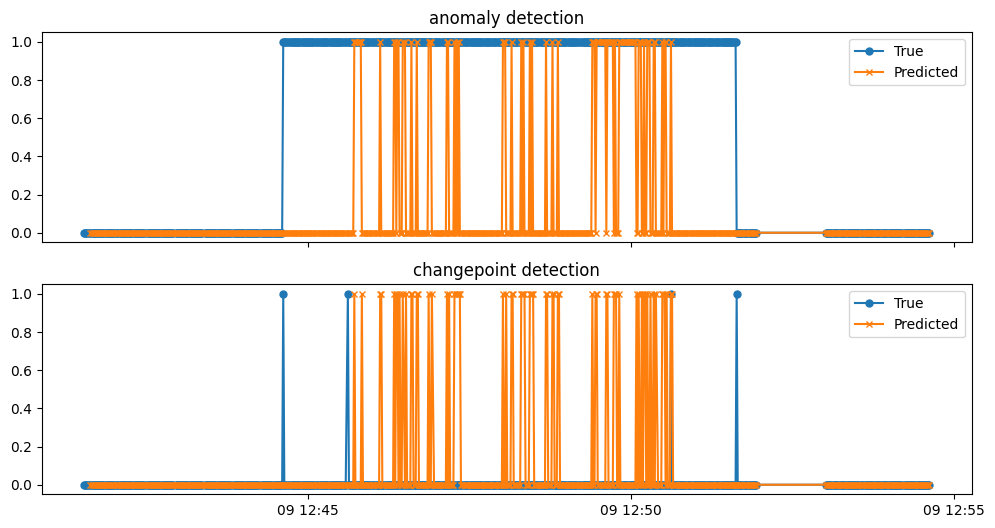

In [7]:
# [donotremove]
plot_results(
    (true_outlier[1], predicted_outlier[1]),
    (true_cp[1], predicted_cp[1]),
)

## Evaluation (metrics calculation)

In [8]:
import pickle

pickle.dump(
    predicted_outlier, open(f"results-{model.__class__.__name__}.pkl", "wb")
)

### Binary classification (outlier detection) metrics

In [9]:
# [donotremove]
# binary classification metrics calculation
binary = chp_score(true_outlier, predicted_outlier, metric="binary")

False Alarm Rate 12.54 %
Missing Alarm Rate 59.53 %
F1 metric 0.54


### Changepoint detection metrics

In [10]:
# [donotremove]
# average detection delay metric calculation
add = chp_score(
    true_cp,
    predicted_cp,
    metric="average_time",
    window_width="60s",
    anomaly_window_destination="righter",
)

Amount of true anomalies 127
A number of missed CPs = 90
A number of FPs = 342
Average time 0 days 00:00:13.756756756


In [11]:
# [donotremove]
# nab metric calculation
nab = chp_score(
    true_cp,
    predicted_cp,
    metric="nab",
    window_width="60s",
    anomaly_window_destination="righter",
)

Standard  -  11.31
LowFP  -  -3.8
LowFN  -  17.25
